<a href="https://colab.research.google.com/github/MartinaKolibasova1/AngularLearning/blob/master/vgg_slices67_82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip3 install SimpleITK

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp "drive/My Drive/DP/image_nifti_2d_dataset.py" .

In [5]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import time
import torchvision.models as models
from image_nifti_2d_dataset import ImageNifti2dDataset as ImageNifti2dDataset
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from statistics import mean 
import torch.nn as nn
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import copy

In [6]:
import pickle

# open a file with the pickled data
file = open('drive/My Drive/DP/Dataloaders/dataloaders_64_ventricles_hippo_mri_masks_slices_67_82_coronal_standard_norm.pickle', 'rb')

# dump information to that file
dataloaders = pickle.load(file)

# close the file

file.close()

In [7]:
dataloaders

{'sizes': {'test': 1455, 'train': 5295, 'val': 780},
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f98ea901c10>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f995b964290>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f98ea99de10>}

In [8]:
from torch import optim, cuda

gpu_count = cuda.device_count()
print(f'{gpu_count} gpus detected.')
if gpu_count > 1:
    multi_gpu = True
else:
    multi_gpu = False

1 gpus detected.


In [9]:
def visualize_data(data):
    fig = plt.figure(figsize=(20, 20))

    fig.add_subplot(131)
    plt.title('before', fontsize=20)
    plt.set_cmap('gray')
    plt.imshow(data)
    plt.show()

In [10]:
def get_cn_ad(dataloaders):
  ad = 0
  cn = 0
  for inputs, mask, labels in dataloaders['train']:
    ad += labels.sum()
    cn += len(labels) - labels.sum()
  
  return cn, ad

In [28]:
dataset_sizes = dataloaders['sizes']

def train_model(model, criterion, optimizer, dataloaders, scheduler = None, num_epochs=25):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss , train_accuracy, train_precision , train_recall = [], [], [], []
    val_loss , val_accuracy, val_precision , val_recall = [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print(f'-----------------{phase}-----------------')
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            running_fp = 0
            running_fn = 0
            running_tp = 0
            running_tn = 0
            # Iterate over data.
            for inputs, masks, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cm = confusion_matrix(labels.data.to('cpu'), preds.to('cpu'), labels=[1,0])

                TP = cm[0][0]
                TN = cm[1][1]
                FN = cm[1][0]
                FP = cm[0][1]

                running_fp += FP
                running_fn += FN
                running_tp += TP
                running_tn += TN
          
                del labels
                del inputs

            if phase == 'train' and scheduler is not None:
              scheduler.step()

            print(f'Running Corrects: {running_corrects} Size: {dataset_sizes[phase]}')
            print(f'Running Loss: {running_loss} Size: {dataset_sizes[phase]}')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            epoch_accuracy = 100. * running_corrects/dataset_sizes[phase]
            epoch_recall = 100. * running_tp/(running_tp + running_fn)
            epoch_precision = 100. * running_tp/(running_tp + running_fp)
            print(f'{phase} Loss: {epoch_loss:.4f}, {phase} Acc: {phase} {epoch_accuracy:.2f}, {phase} Recall: {epoch_recall:.2f}, {phase} Precision: {epoch_precision:.2f}')


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
              train_loss.append(epoch_loss)
              train_accuracy.append(epoch_accuracy)
              train_recall.append(epoch_recall)
              train_precision.append(epoch_precision)
            else: 
              val_loss.append(epoch_loss)
              val_accuracy.append(epoch_accuracy)
              val_recall.append(epoch_recall)
              val_precision.append(epoch_precision)   
        print()

    get_metrics(train_accuracy, train_precision, train_recall, val_accuracy, val_precision, val_recall)
    visualize_plotly(train_accuracy, val_accuracy, num_epochs)
    visualize_plotly(train_loss, val_loss, num_epochs)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [35]:
 def x(model, device, test_loader):
    model.eval()
    actuals = []
    probabilities = []
    probabilities
    with torch.no_grad():
        for data, mask, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.float())
            outputs_softmax = torch.nn.functional.log_softmax(output, dim = 1)
            _, preds = torch.max(output.data, 1)
            actuals.extend(target.data.cpu())
            probabilities.extend(_.data.cpu()) 

    return actuals, probabilities

In [34]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    probabilities
    with torch.no_grad():
        for data, mask, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.float())

            prediction = output.argmax(dim=1, keepdim=True)
            # print(prediction)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class].cpu()))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

In [12]:
def get_metrics(train_accuracy, train_precision, train_recall, val_accuracy, val_precision, val_recall):
  print("Mean train accuracy: " + str(sum(train_accuracy)/len(train_accuracy)))
  print("Mean train recall: " + str(sum(train_precision)/len(train_precision)))
  print("Mean train precision: " + str(sum(train_recall)/len(train_recall)))

  print("Mean val accuracy: " + str(sum(val_accuracy)/len(val_accuracy)))
  print("Mean val recall: " + str(sum(val_precision)/len(val_precision)))
  print("Mean val precision: " + str(sum(val_recall)/len(val_recall)))

  print("MAX train accuracy: " + str(max(train_accuracy)))
  print("MAX train recall: " + str(max(train_precision)))
  print("MAX train precision: " + str(max(train_recall)))

  print("MAX val accuracy: " + str(max(val_accuracy)))
  print("MAX val recall: " + str(max(val_precision)))
  print("MAX val precision: " + str(max(val_recall)))

In [13]:
def visualize(train_accuracy, val_accuracy):
  plt.figure(figsize=(10, 7))
  plt.plot(train_accuracy, color='green', label='train accuracy')
  plt.plot(val_accuracy, color='blue', label='validataion accuracy')
  plt.legend()
  plt.savefig('accuracy.png')
  plt.show()

In [27]:
import plotly.express as px

def visualize_plotly(train_accuracy, val_accuracy, epochs):
    train = np.full(
        shape=len(train_accuracy),
        fill_value='train',
        dtype=np.str)

    val = np.full(
        shape=len(val_accuracy),
        fill_value='val',
        dtype=np.str)

    epoch = np.concatenate([np.arange(1, epochs + 1), np.arange(1, epochs + 1)])

    labels = np.concatenate([train, val])

    acc_all = np.concatenate([train_accuracy, val_accuracy])

    df = pd.DataFrame({'accuracy': acc_all, 'label': labels, 'epoch': epoch})

    fig = px.line(df, x="epoch", y="accuracy", color='label')
    fig.show()

In [15]:
cn, ad = get_cn_ad(dataloaders)

In [16]:
print(f'AD: {ad}, CN: {cn}')

AD: 3225, CN: 2070


In [17]:
np.true_divide(torch.tensor([cn.item(), ad.item()]), ad + cn.item()).float()

tensor([0.3909, 0.6091])

In [18]:
weight = np.true_divide(torch.tensor([cn.item(), ad.item()]), ad + cn.item()).float()

In [21]:
model_ft = models.vgg13(pretrained=True)

for param in model_ft.features.parameters():
  param.requires_grad_(False)

model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight.to(device))

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, num_epochs=30)
# Save model
torch.save(model_ft.state_dict(), 'vgg13.pt')

Epoch 0/29
----------
-----------------train-----------------
Running Corrects: 3552 Size: 5295
Running Loss: 2847.4785244464874 Size: 5295
train Loss: 0.5378, train Acc: train 67.08, train Recall: 66.28, train Precision: 93.55
train Loss: 0.5378 Acc: 0.6708
-----------------val-----------------
Running Corrects: 561 Size: 780
Running Loss: 403.34740257263184 Size: 780
val Loss: 0.5171, val Acc: val 71.92, val Recall: 79.50, val Precision: 82.98
val Loss: 0.5171 Acc: 0.7192

Epoch 1/29
----------
-----------------train-----------------
Running Corrects: 4321 Size: 5295
Running Loss: 1910.020146816969 Size: 5295
train Loss: 0.3607, train Acc: train 81.61, train Recall: 80.04, train Precision: 92.99
train Loss: 0.3607 Acc: 0.8161
-----------------val-----------------
Running Corrects: 605 Size: 780
Running Loss: 323.06153321266174 Size: 780
val Loss: 0.4142, val Acc: val 77.56, val Recall: 81.60, val Precision: 89.47
val Loss: 0.4142 Acc: 0.7756

Epoch 2/29
----------
-----------------tr

Training complete in 20m 34s
Best val Acc: 0.775641


In [23]:
model_ft = models.vgg13(pretrained=True)

for param in model_ft.features.parameters():
  param.requires_grad_(False)

feats_list = list(model_ft.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

# modify convolution layers
model_ft.features = nn.Sequential(*new_feats_list)

model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight.to(device))

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, num_epochs=30)
# Save model
torch.save(model_ft.state_dict(), 'vgg13_AdamW.pt')

Epoch 0/29
----------
-----------------train-----------------
Running Corrects: 3096 Size: 5295
Running Loss: 4325.500290811062 Size: 5295
train Loss: 0.8169, train Acc: train 58.47, train Recall: 61.99, train Precision: 82.26
train Loss: 0.8169 Acc: 0.5847
-----------------val-----------------
Running Corrects: 590 Size: 780
Running Loss: 508.65438055992126 Size: 780
val Loss: 0.6521, val Acc: val 75.64, val Recall: 77.54, val Precision: 93.86
val Loss: 0.6521 Acc: 0.7564

Epoch 1/29
----------
-----------------train-----------------
Running Corrects: 3259 Size: 5295
Running Loss: 3334.87103164196 Size: 5295
train Loss: 0.6298, train Acc: train 61.55, train Recall: 62.46, train Precision: 92.43
train Loss: 0.6298 Acc: 0.6155
-----------------val-----------------
Running Corrects: 582 Size: 780
Running Loss: 500.0758512020111 Size: 780
val Loss: 0.6411, val Acc: val 74.62, val Recall: 74.73, val Precision: 98.60
val Loss: 0.6411 Acc: 0.7462

Epoch 2/29
----------
-----------------train

Training complete in 23m 42s
Best val Acc: 0.760256


In [31]:
model_ft = models.vgg13(pretrained=True)

for param in model_ft.features.parameters():
  param.requires_grad_(False)

feats_list = list(model_ft.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

# modify convolution layers
model_ft.features = nn.Sequential(*new_feats_list)

model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight.to(device))

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, num_epochs=100)
# Save model
torch.save(model_ft.state_dict(), 'vgg13_AdamW_100_0.2.pt')

Epoch 0/99
----------
-----------------train-----------------
Running Corrects: 3060 Size: 5295
Running Loss: 4433.1400846242905 Size: 5295
train Loss: 0.8372, train Acc: train 57.79, train Recall: 61.63, train Precision: 81.36
train Loss: 0.8372 Acc: 0.5779
-----------------val-----------------
Running Corrects: 568 Size: 780
Running Loss: 495.8306658267975 Size: 780
val Loss: 0.6357, val Acc: val 72.82, val Recall: 73.01, val Precision: 99.65
val Loss: 0.6357 Acc: 0.7282

Epoch 1/99
----------
-----------------train-----------------
Running Corrects: 3218 Size: 5295
Running Loss: 3320.4464549422264 Size: 5295
train Loss: 0.6271, train Acc: train 60.77, train Recall: 62.08, train Precision: 91.47
train Loss: 0.6271 Acc: 0.6077
-----------------val-----------------
Running Corrects: 570 Size: 780
Running Loss: 484.8841338157654 Size: 780
val Loss: 0.6216, val Acc: val 73.08, val Recall: 73.08, val Precision: 100.00
val Loss: 0.6216 Acc: 0.7308

Epoch 2/99
----------
-----------------tr

Training complete in 78m 59s
Best val Acc: 0.779487


[tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0)

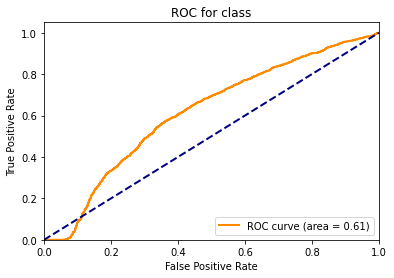

In [37]:
from sklearn.metrics import roc_curve, auc

actuals, class_probabilities = x(model_ft, device, dataloaders['train'])

print(actuals)
print(class_probabilities)
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for class')
plt.legend(loc="lower right")
plt.show()

[tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1)

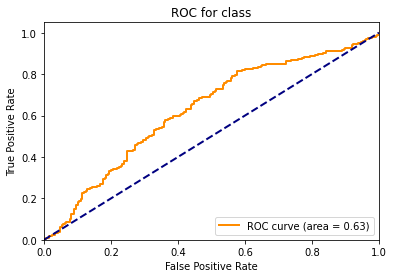

In [38]:
actuals, class_probabilities = x(model_ft, device, dataloaders['val'])

print(actuals)
print(class_probabilities)
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for class')
plt.legend(loc="lower right")
plt.show()

[tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1)

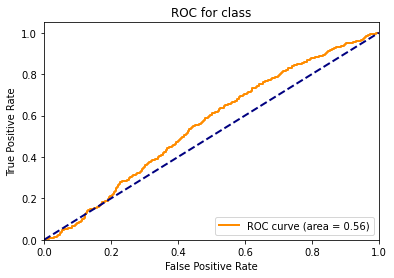

In [44]:
actuals, class_probabilities = x(model_ft, device, dataloaders['test'])

print(actuals)
print(class_probabilities)
fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for class')
plt.legend(loc="lower right")
plt.show()

In [52]:
correct = 0
total = 0

running_fp = 0
running_fn = 0
running_tp = 0
running_tn = 0

epoch_loss = 0
epoch_acc = 0
epoch_accuracy = 0
epoch_recall = 0
epoch_precision = 0 

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for inputs, masks, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(inputs.float())
        # the class with the highest energy is what we choose as prediction
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        cm = confusion_matrix(labels.data.to('cpu'), preds.to('cpu'), labels=[1,0])

        TP = cm[0][0]
        TN = cm[1][1]
        FN = cm[1][0]
        FP = cm[0][1]

        running_fp += FP
        running_fn += FN
        running_tp += TP
        running_tn += TN

epoch_acc = correct / dataset_sizes['test']


epoch_accuracy = 100. * correct/dataset_sizes['test']
epoch_recall = 100. * running_tp/(running_tp + running_fn)
epoch_precision = 100. * running_tp/(running_tp + running_fp)

print(f'Accuracy: {epoch_accuracy} Recall: {epoch_recall} Precision: {epoch_precision} F1: {(2*epoch_precision*epoch_recall)/(epoch_precision + epoch_recall)}')

print(f'Accuracy of the network on the {dataloaders["sizes"]["test"]} test images: %d %%' % (
    100 * correct / total))

Accuracy: 71.54639175257732 Recall: 72.93762575452716 Precision: 83.33333333333333 F1: 77.78969957081546
Accuracy of the network on the 1455 test images: 71 %


In [55]:
model_ft_ = models.vgg13(pretrained=True)

for param in model_ft_.features.parameters():
  param.requires_grad_(False)

feats_list = list(model_ft_.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.4, inplace=True))

# modify convolution layers
model_ft_.features = nn.Sequential(*new_feats_list)

model_ft_.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

model_ft_ = model_ft_.to(device)

criterion = nn.CrossEntropyLoss(weight.to(device))

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft_.parameters(), lr=0.0001)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft_ = train_model(model_ft_, criterion, optimizer_ft, dataloaders, num_epochs=50)
# Save model
torch.save(model_ft_.state_dict(), 'vgg13_50_AdamW.pt')

Epoch 0/49
----------
-----------------train-----------------
Running Corrects: 3205 Size: 5295
Running Loss: 3661.0635808110237 Size: 5295
train Loss: 0.6914, train Acc: train 60.53, train Recall: 62.37, train Precision: 88.74
train Loss: 0.6914 Acc: 0.6053
-----------------val-----------------
Running Corrects: 570 Size: 780
Running Loss: 477.22158122062683 Size: 780
val Loss: 0.6118, val Acc: val 73.08, val Recall: 73.08, val Precision: 100.00
val Loss: 0.6118 Acc: 0.7308

Epoch 1/49
----------
-----------------train-----------------
Running Corrects: 3371 Size: 5295
Running Loss: 3110.879088252783 Size: 5295
train Loss: 0.5875, train Acc: train 63.66, train Recall: 64.08, train Precision: 91.78
train Loss: 0.5875 Acc: 0.6366
-----------------val-----------------
Running Corrects: 522 Size: 780
Running Loss: 488.7853729724884 Size: 780
val Loss: 0.6266, val Acc: val 66.92, val Recall: 71.31, val Precision: 91.58
val Loss: 0.6266 Acc: 0.6692

Epoch 2/49
----------
-----------------tr

In [ ]:
model_ft_ = models.vgg13(pretrained=True)

for param in model_ft_.features.parameters():
  param.requires_grad_(False)

feats_list = list(model_ft_.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

# modify convolution layers
model_ft_.features = nn.Sequential(*new_feats_list)

model_ft_.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

model_ft_ = model_ft_.to(device)

criterion = nn.CrossEntropyLoss(weight.to(device))

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft_.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft_ = train_model(model_ft_, criterion, optimizer_ft, dataloaders, exp_lr_scheduler, num_epochs=50)
# Save model
torch.save(model_ft_.state_dict(), 'vgg13_50_AdamW.pt')